In [308]:
import os

import numpy as np

import pandas as pd
import geopandas as gpd
from shapely import Point
from shapely.geometry import LineString

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import dask

In [335]:
gdf = gpd.read_file("labeled_trajectories-all.geoJSON")
zones = gpd.read_file("C:/Users/anape/Downloads/outsight/resources/QGIS/lanes_and_int.geojson")

<Axes: >

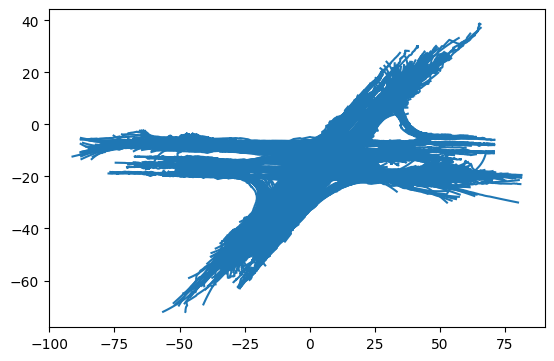

In [336]:
gdf.plot()

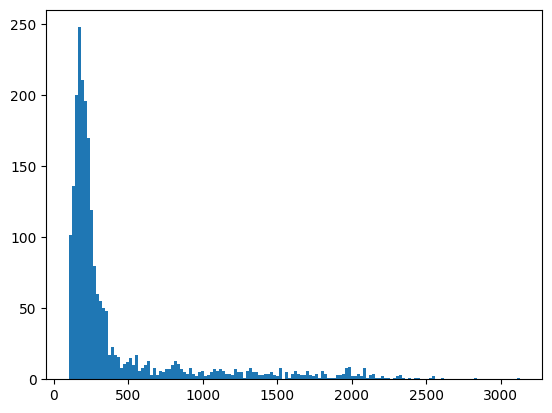

In [337]:
trajectories = list(gdf['geometry'])
points = [len(list(trajectory.coords)) for trajectory in trajectories]
plt.hist(points,bins=150)
plt.show()

In [338]:
def interpolate_trajectories(gdf, interpolation):
    interpolated_trajectories = []

    for point in gdf['geometry']:
        interpolated_points = [
            point.interpolate(i / (interpolation - 1), normalized=True).coords[0]
            for i in range(interpolation)
        ]
        interpolated_line = LineString(interpolated_points)
        interpolated_trajectories.append(interpolated_line)
        
    columns_to_copy = gdf.columns.difference(['geometry'])  # Exclude 'geometry' column

    interpolated_gdf = gpd.GeoDataFrame(
        gdf[columns_to_copy], geometry=interpolated_trajectories, crs=gdf.crs
    )
    
    return interpolated_gdf

In [339]:
def calc_mean_std(gdf,interpolation):
    mean_geometries = []
    mean_counts = []
    mean_clusters = []
    std_x_list = []
    std_y_list = []

    for c in np.arange(0,11,1):
        curr_gdf = gdf[gdf['cluster']==c]
        trajectories = list(curr_gdf['geometry'])

    # Interpolate each trajectory to have the same number of points (based on the maximum number)
        interpolated_trajectories = []
        for trajectory in trajectories:
            interpolated_points = [trajectory.interpolate(i / (interpolation - 1), normalized=True) for i in range(interpolation)]
            interpolated_trajectories.append(interpolated_points)

        # Calculate the mean trajectory point-wise
        mean_points = []
        std_x = []
        std_y = []
        for i in range(interpolation):
            x_sum, y_sum = 0, 0
            x_var, y_var = 0, 0
            for trajectory in interpolated_trajectories:
                x, y = trajectory[i].coords[0]
                x_sum += x
                y_sum += y
            mean_x = x_sum / len(interpolated_trajectories)
            mean_y = y_sum / len(interpolated_trajectories)
            mean_points.append(Point(mean_x, mean_y))

            for trajectory in interpolated_trajectories:
                x, y = trajectory[i].coords[0]
                x_var += (x - mean_x)**2
                y_sum += (y - mean_y)**2
            std_x.append((x_var/(interpolation-1))**0.5)
            std_y.append((y_var/(interpolation-1))**0.5)

        mean_trajectory = LineString(mean_points)
        mean_geometries.append(mean_trajectory)
        mean_counts.append(len(curr_gdf))
        mean_clusters.append(c)
        std_x_list.append(std_x)
        std_y_list.append(std_y)
            
    means = gpd.GeoDataFrame({'geometry': mean_geometries, 'counts': mean_counts, 'cluster': mean_clusters, 'std_x' : std_x_list, 'std_y' : std_y_list})
    return means

In [340]:
def plot_means(gdf,means,interpolation):
    color_map = {
        0: 'salmon', 1: 'deepskyblue', 2: 'gold', 3: 'orange', 4: 'violet',
        5: 'springgreen', 6: 'mediumslateblue', 7: 'magenta', 8: 'brown', 9: 'olivedrab', 10: 'hotpink'
    }
    colors = means['cluster'].map(color_map)

    fig,ax = plt.subplots()

    gdf.plot(color='lightgray', linewidth=0.3, ax=ax)
    means.plot(color=colors, linewidth=2, ax=ax)
    ax.axis('off')
    ax.set_title(f'{interpolation}-point mean trajectories')
    legend_handles = [mpatches.Patch(color=color, label=f'{cluster}') for cluster, color in color_map.items()]
    ax.legend(handles=legend_handles,loc='lower right',prop={'size': 5})

    plt.show()

In [341]:
def plot_std_intervals(means,z,interpolation):
    color_map = {
        0: 'salmon', 1: 'deepskyblue', 2: 'gold', 3: 'orange', 4: 'violet',
        5: 'springgreen', 6: 'mediumslateblue', 7: 'magenta', 8: 'brown', 9: 'olivedrab', 10: 'hotpink'
    }
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))

    # Iterate through the rows and plot in subplots
    for i, ax in enumerate(axes.ravel()):
        zones.plot(color='gray', alpha=0.2, ax=ax)
        start = i * 3
        end = start + 3 if i < 3 else len(means)
        subset = means.iloc[start:end]

        subset_clusters = set()  # Store unique clusters in the subset
        for index, row in subset.iterrows():
            x_mean, y_mean = row['geometry'].xy
            upper_x = [x + z * std for x, std in zip(x_mean, row['std_x'])]
            lower_x = [x - z * std for x, std in zip(x_mean, row['std_x'])]
            upper_y = [y + z * std for y, std in zip(y_mean, row['std_y'])]
            lower_y = [y - z * std for y, std in zip(y_mean, row['std_y'])]

            ax.plot(x_mean, y_mean, color='black', linewidth=0.7)
            ax.fill_betweenx(upper_y, upper_x, lower_x, color=color_map[row['cluster']], alpha=0.5)

            subset_clusters.add(row['cluster'])  # Add cluster to the subset

        #ax.legend(handles=subset_legend_handles, loc='upper left', prop={'size': 8})
        ax.axis('off')

    fig.suptitle(f'{interpolation}-point interpolation mean trajectories with {z} st.d. interval')

    plt.tight_layout()
    plt.show()

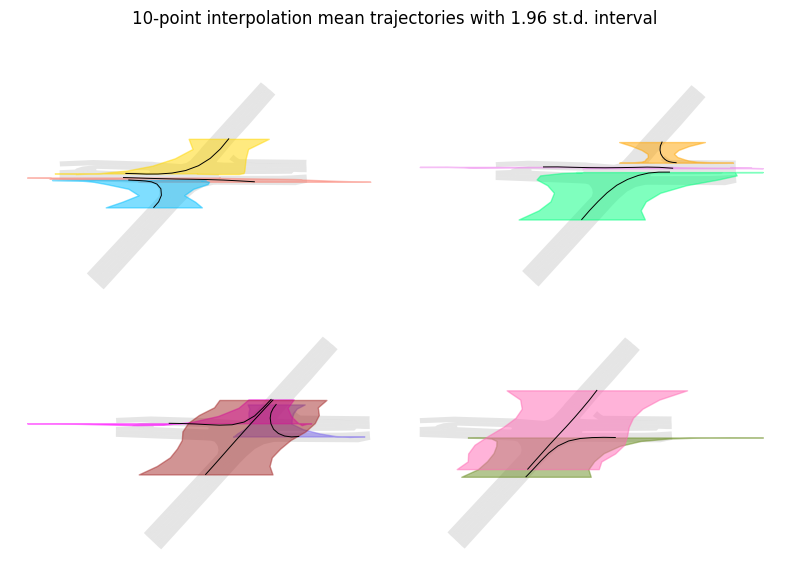

In [342]:
means_10 = calc_mean_std(gdf,10)
plot_std_intervals(means_10,1.96,10)

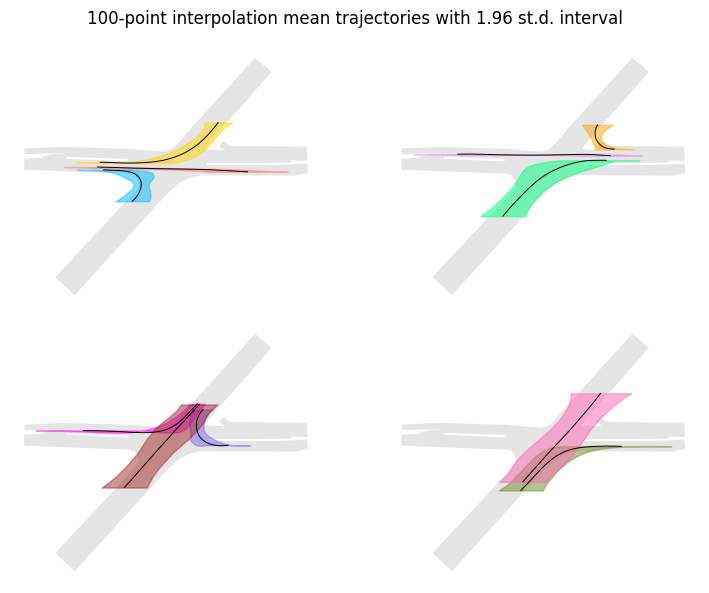

In [343]:
means_100 = calc_mean_std(gdf,100)
plot_std_intervals(means_100,1.96,100)

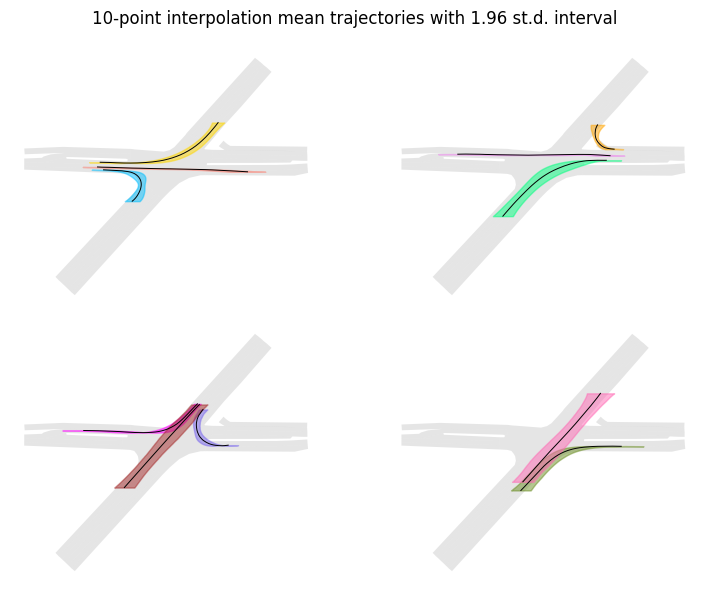

In [344]:
means_500 = calc_mean_std(gdf,500)
plot_std_intervals(means_500,1.96,10)

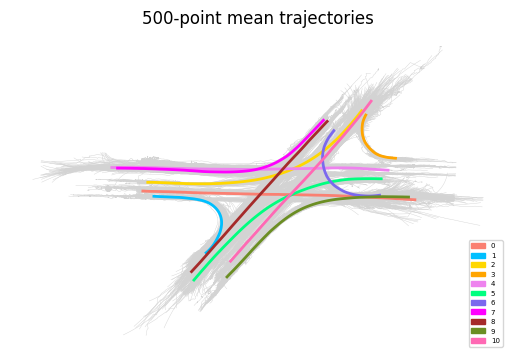

In [345]:
plot_means(gdf,means=means_500,interpolation=500)

In [346]:
means_500 = means_500.rename(columns={'geometry': 'mean_geometry'}).drop(columns = ['counts','std_x','std_y'])
joined_gdf = gdf.merge(means_500, on='cluster', how='left')

## Undirected Hausdorff distance from mean

In [321]:
from scipy.spatial.distance import directed_hausdorff
import shapely

@dask.delayed
def undirected_hausdorff_distance(row):
    '''
    :param line1: shapely.Linestring object
    :param line2: shapely.Linestring object

    :return: undirected Hausdorff distance between the two lines (float)
    '''
    line1 = row['geometry']
    line2 = row['mean_geometry']
    distance = line1.hausdorff_distance(line2)
    return distance

In [322]:
delayed_results = []
for index, row in joined_gdf.iterrows():
    delayed_result = undirected_hausdorff_distance(row)
    delayed_results.append(delayed_result)

# Compute the delayed results
computed_results = dask.compute(*delayed_results)

# Assign computed results to the DataFrame
joined_gdf['distance_from_mean'] = computed_results

c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:224: RuntimeWarning: invalid value encountered in hausdorff_distance
  return lib.hausdorff_distance(a, b, **kwargs)


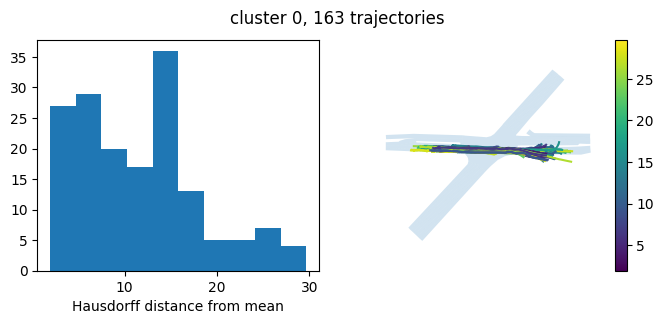

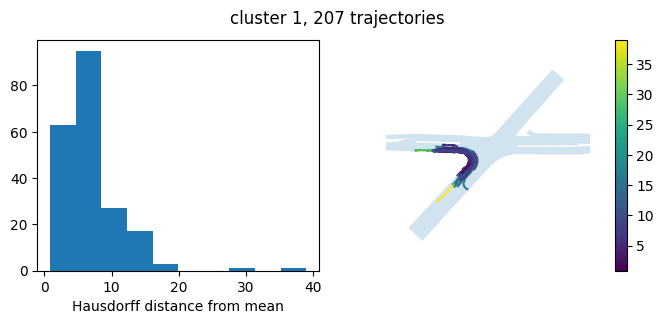

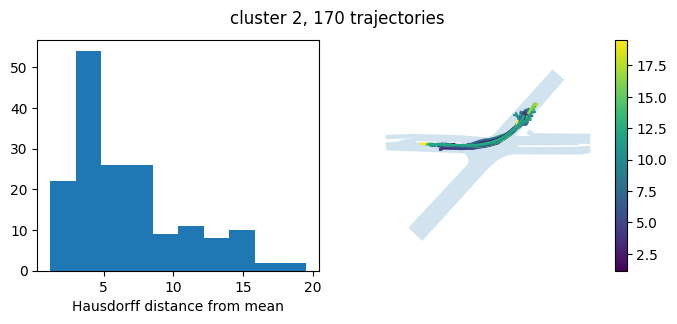

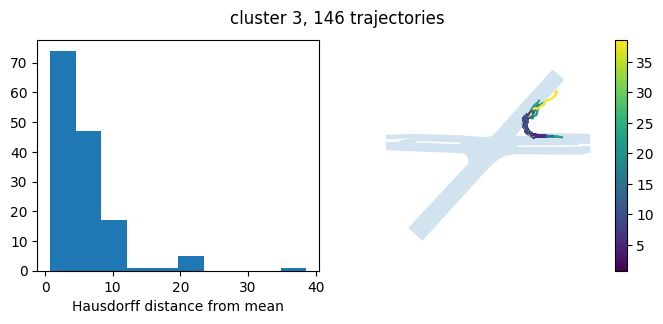

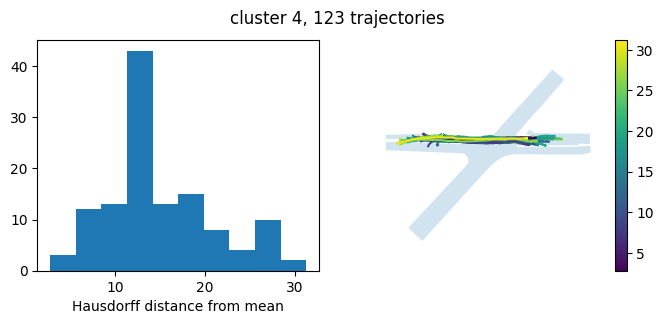

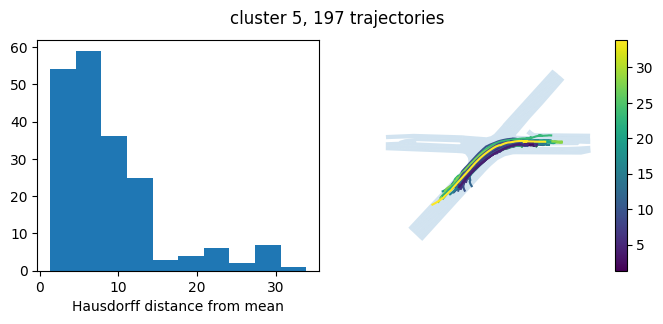

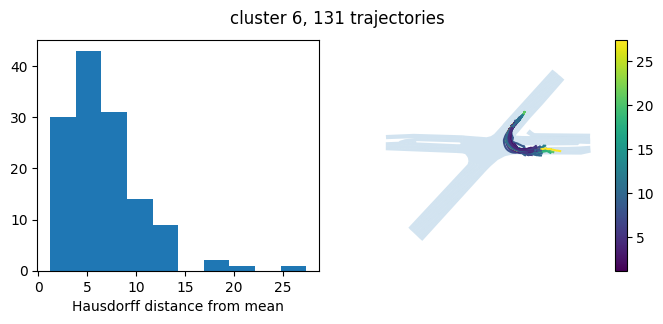

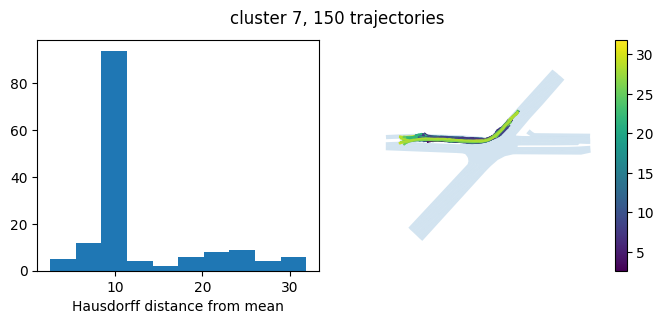

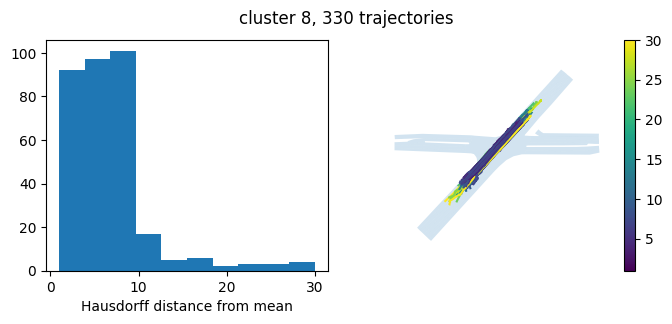

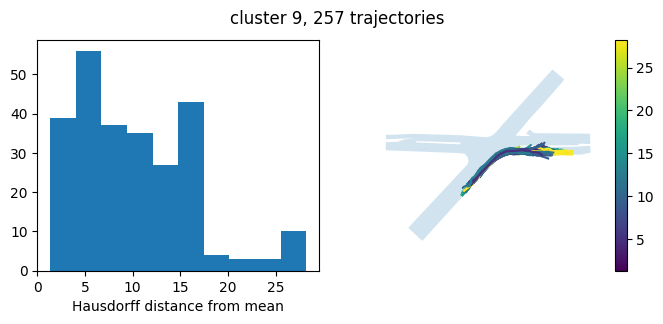

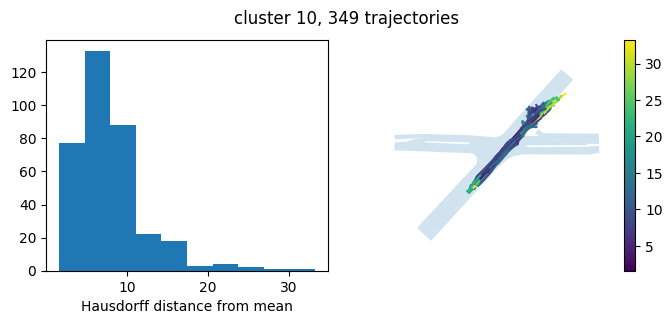

In [323]:
for i, group in joined_gdf.groupby('cluster'):
    fig, axes = plt.subplots(1,2, figsize=(8,3))
    ax = axes[0]
    ax.hist(group['distance_from_mean'])
    ax.set_xlabel('Hausdorff distance from mean')

    ax = axes[1]
    zones.plot(alpha=0.2,ax=ax)
    group.plot(column='distance_from_mean',ax=ax, legend=True)
    ax.axis('off')
    fig.suptitle(f'cluster {i}, {len(group)} trajectories')
    plt.show()

## Directed Hausdorff distance from mean

The Hausdorff distance from the mean trajectory does not seem like a robust way to prune outliers. For example, in clusters 1,3 and 8, the trajectories furtherst away from the mean are the long ones, not those which have weird artifacts to them. That makes sense - the majority of trajectories are shorter, skewing the mean in this direction.


Traditionally, the Hausdorff distance is undirected and symmetric, meaning it takes the maximum of the two directed distances from A to B and B to A. However, I'm more interested in how far the mean trajectory is from the trajectory (how well it describes the trajectory), rather than the opposite, which would penalize longer instances. Therefore, I try the same approach using directed Hausdorff distance.


In [248]:
@dask.delayed
def directed_hausdorff_distance(row):
    '''
    :param: row in a dataframe with Linestring 'geometry' and 'mean_geometry' columns

    :return: directed Hausdorff distance from line1 to line2 (float)
    '''
    line1 = row['mean_geometry']
    line2 = row['geometry']
    distance = directed_hausdorff(list(zip(*line1.xy)),list(zip(*line2)))
    return distance[0]/(line2.length/line1.length)

In [254]:
delayed_results = []
for index, row in joined_gdf.iterrows():
    delayed_result = directed_hausdorff_distance(row)
    delayed_results.append(delayed_result)

# Compute the delayed results
computed_results = dask.compute(*delayed_results)

# Assign computed results to the DataFrame
joined_gdf['d_distance_from_mean'] = computed_results

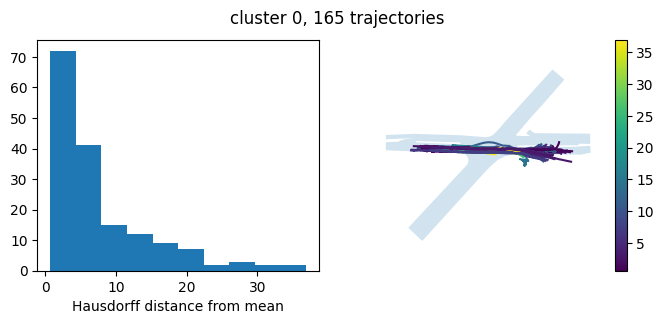

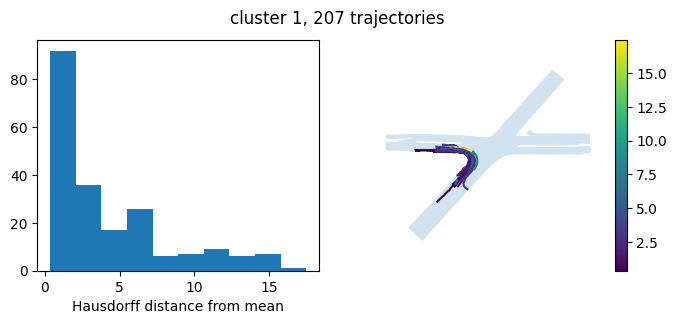

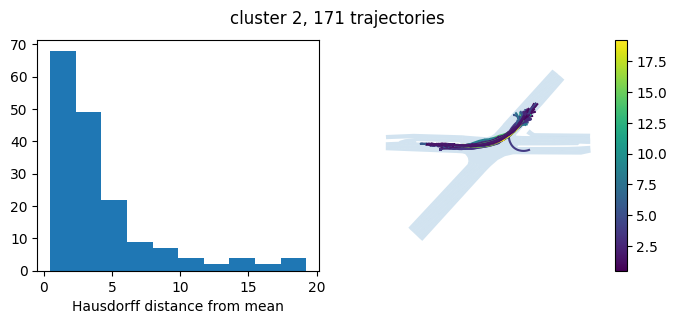

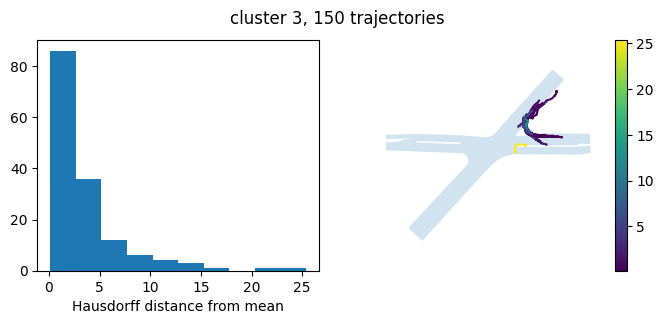

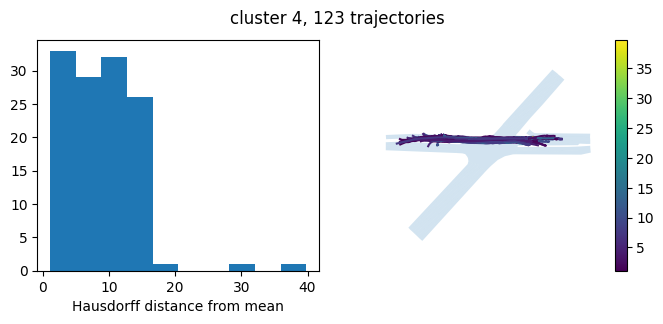

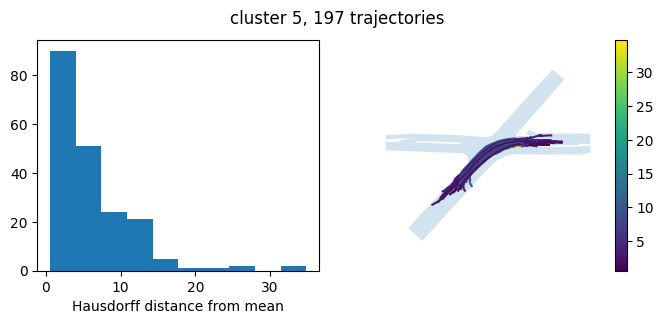

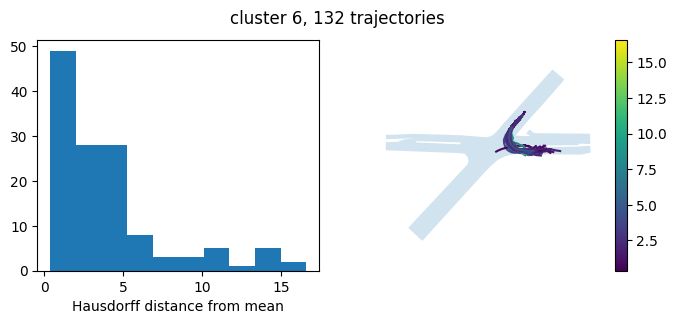

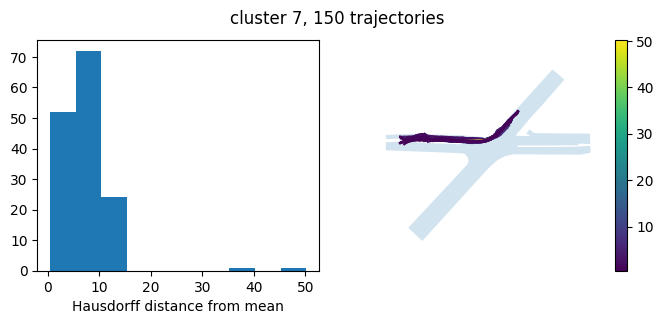

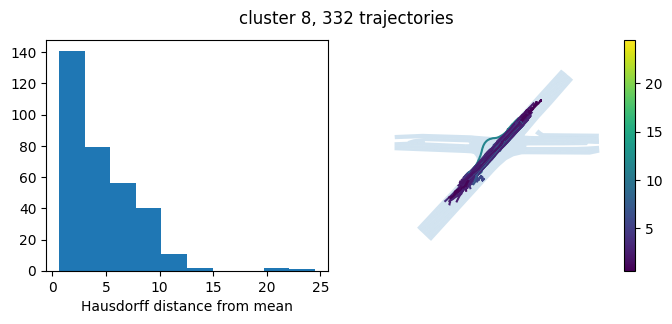

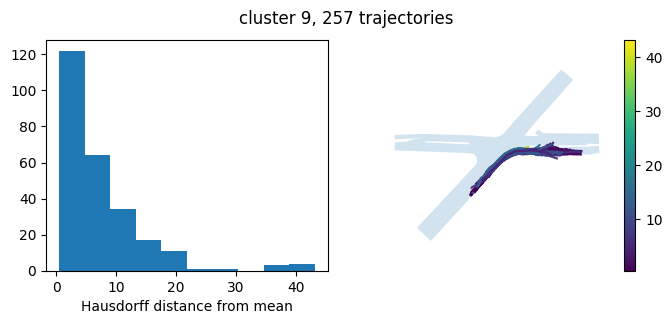

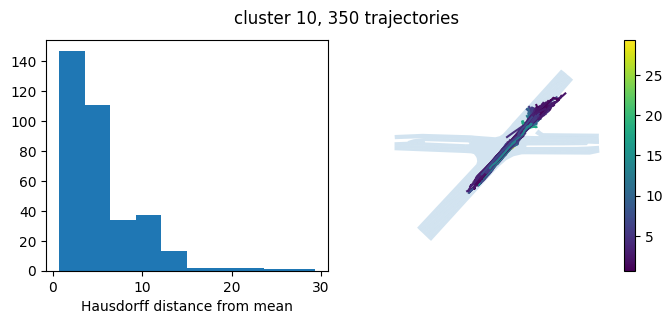

In [255]:
for i, group in joined_gdf.groupby('cluster'):
    fig, axes = plt.subplots(1,2, figsize=(8,3))
    ax = axes[0]
    ax.hist(group['d_distance_from_mean'])
    ax.set_xlabel('Hausdorff distance from mean')

    ax = axes[1]
    zones.plot(alpha=0.2,ax=ax)
    group.plot(column='d_distance_from_mean',ax=ax, legend=True)
    ax.axis('off')
    fig.suptitle(f'cluster {i}, {len(group)} trajectories')
    plt.show()

The directed distance does not work very well either.

In [ ]:
# @dask.delayed
# def convex_distance(i, group):
#     '''
#     :param line1: shapely.Linestring object
#     :param line2: shapely.Linestring object

#     :return: Hausdorff distance between the two lines (float)
#     '''
#     group_multi = list(group[~group.index==i]['geometry'])
#     group_multi = shapely.MultiLineString(group_multi)
#     return group_multi.convex_hull.area
# delayed_res = []

# for cluster, group in joined_gdf.groupby('cluster'):
#     mult = list(group['geometry'])
#     mult = shapely.MultiLineString(mult)
#     bigarea = mult.convex_hull.area

#     for i, row in group.iterrows():
#         delayed_result = (bigarea - convex_distance(i, group))/1000
#         delayed_res.append(delayed_result)

# # Compute the delayed results
# computed_results = dask.compute(*delayed_res)

# # Assign computed results to the DataFrame
# joined_gdf['distance_conv'] = computed_results

## As parametric functions

The Hausdorff distance method penalizes longer trajectories.

Perhaps it makes sense to describe the trajectories as a continuous entity, for example a function. A curve is fitted to the mean trajectory, but it is defined beyond its domain, therefore allowing extending the trajectory.

I model the means using a parametric equation, i.e. one where the x and y coordinates of the curve are both written as functions of a third variable. This is necessary since a simple $y = f(x)$ relationship cannot model curves that don't pass the vertical line test.

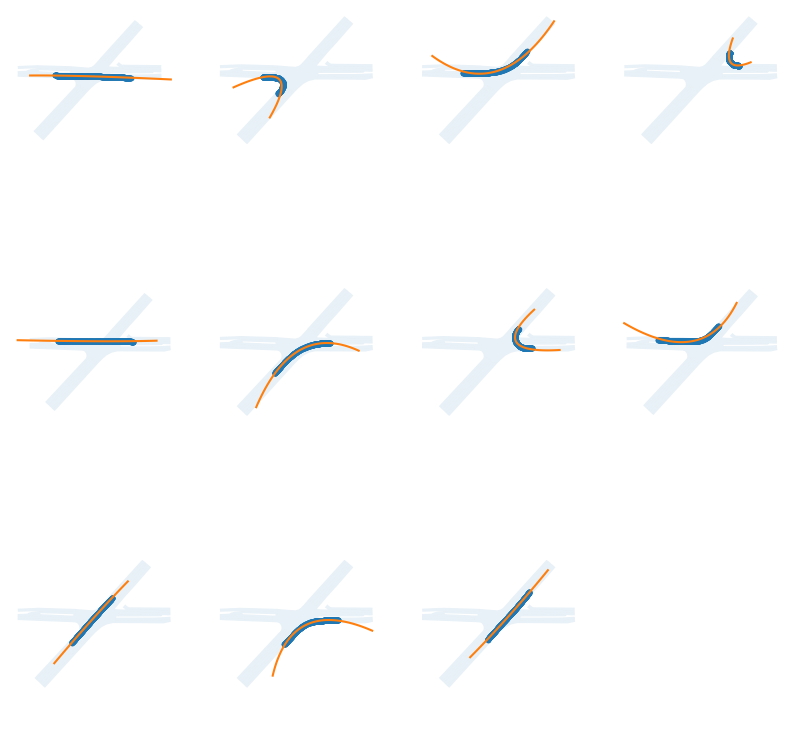

In [221]:
fig, axes = plt.subplots(3,4, figsize=(10,10))

for i in range(11):
    cluster1 = means_500['mean_geometry'][i]


    x = cluster1.xy[0]
    y = cluster1.xy[1]
    t = np.arange(len(x))


    fitx = np.poly1d(np.polyfit(t, x, 2))
    fity = np.poly1d(np.polyfit(t, y, 2))

    # # calculate new x's and y's
    t_new = np.linspace(min(t)-200, max(t)+200, 100)
    # x_new = np.linspace(min(x), max(x), 100)
    x_new = fitx(t_new)
    y_new = fity(t_new)

    ax = axes.flatten()[i]
    ax.plot(x,y,'.', x_new, y_new,)
    zones.plot(alpha=0.1,ax=ax)
    ax.axis('off')

axes[2][3].axis('off')
plt.show()

The curves fit well but the function is only fitted in the domain of the known points.

_____________________________________________________
# Synthetic with sampling from a distribution

In [22]:
def synthetic_trajectories(gdf, interpolation, samples):
    mean_points = {}
    cov_matrices = {}
    
    for c in np.arange(0, 11, 1):
        curr_gdf = gdf[gdf['cluster'] == c]
        trajectories = list(curr_gdf['geometry'])

        curr_mean_points = []
        curr_cov_matrices = []

        # Interpolate each trajectory to have the same number of points (based on the maximum number)
        interpolated_trajectories = []
        for trajectory in trajectories:
            interpolated_points = [trajectory.interpolate(i / (interpolation - 1), normalized=True) for i in range(interpolation)]
            interpolated_trajectories.append(interpolated_points)

        # Calculate the mean trajectory point-wise
        for i in range(interpolation):
            points_at_step = [trajectory[i].coords[0] for trajectory in interpolated_trajectories]
            x_values, y_values = zip(*points_at_step)
            
            mean_x = np.mean(x_values)
            mean_y = np.mean(y_values)
            curr_mean_points.append((mean_x, mean_y))
            
            # Covariance matrix calculation
            cov_matrix = np.cov(np.array([x_values, y_values]))
            curr_cov_matrices.append(cov_matrix)

        mean_points[c] = curr_mean_points
        cov_matrices[c] = curr_cov_matrices    
    return mean_points, cov_matrices


In [23]:
import numpy as np
import geopandas as gpd
from shapely.geometry import LineString

def calculate_means_covariates(gdf, interpolation):
    mean_points = {}
    cov_matrices = {}
    
    for c in np.arange(0, 11, 1):
        curr_gdf = gdf[gdf['cluster'] == c]
        trajectories = list(curr_gdf['geometry'])

        curr_mean_points = []
        curr_cov_matrices = []

        # Interpolate each trajectory to have the same number of points (based on the maximum number)
        interpolated_trajectories = []
        for trajectory in trajectories:
            interpolated_points = [trajectory.interpolate(i / (interpolation - 1), normalized=True) for i in range(interpolation)]
            interpolated_trajectories.append(interpolated_points)

        # Calculate the mean trajectory point-wise
        for i in range(interpolation):
            points_at_step = [trajectory[i].coords[0] for trajectory in interpolated_trajectories]
            x_values, y_values = zip(*points_at_step)
            
            mean_x = np.mean(x_values)
            mean_y = np.mean(y_values)
            curr_mean_points.append((mean_x, mean_y))
            
            # Covariance matrix calculation
            cov_matrix = np.cov(np.array([x_values, y_values]))
            curr_cov_matrices.append(cov_matrix)

        mean_points[c] = curr_mean_points
        cov_matrices[c] = curr_cov_matrices
    
    return mean_points, cov_matrices

def generate_synthetic_trajectories(gdf, samples, interpolation, std_scale=1, double_interpolation = None):
    mean_points, cov_matrices = calculate_means_covariates(gdf, interpolation)
    synthetic_trajectories = []
    
    for c in np.arange(0, 11, 1):
        mean_points_c = mean_points[c]
        cov_matrices_c = cov_matrices[c]
        
        for _ in range(samples):
            synthetic_points = []
            for i in range(interpolation):
                x = np.random.normal(mean_points_c[i][0], np.sqrt(cov_matrices_c[i][0, 0])/std_scale)
                y = np.random.normal(mean_points_c[i][1], np.sqrt(cov_matrices_c[i][1, 1])/std_scale)
                synthetic_points.append((x, y))
            synthetic_line = LineString(synthetic_points)

            # if double_interpolation != None:
            #     interpolated_points = [synthetic_line.interpolate(i / (double_interpolation - 1), normalized=True) for i in range(double_interpolation)]
            #     synthetic_line = LineString(interpolated_points)

            synthetic_trajectories.append((c, synthetic_line))

    synthetic_gdf = gpd.GeoDataFrame(
        synthetic_trajectories, columns=['cluster', 'geometry'], crs=gdf.crs
    )
    
    return synthetic_gdf

In [24]:
newdataset = generate_synthetic_trajectories(gdf,1,500,std_scale=10)

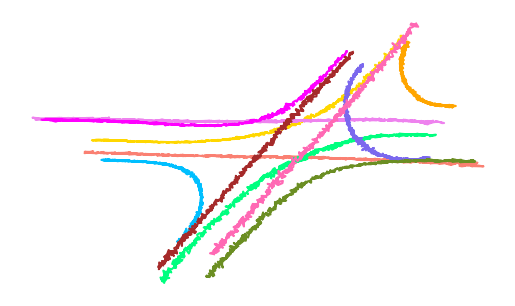

In [25]:
color_map = {
        0: 'salmon', 1: 'deepskyblue', 2: 'gold', 3: 'orange', 4: 'violet',
        5: 'springgreen', 6: 'mediumslateblue', 7: 'magenta', 8: 'brown', 9: 'olivedrab', 10: 'hotpink'
    }
colors = newdataset['cluster'].map(color_map)
newdataset.plot(color=colors)
plt.axis('off')
plt.show()

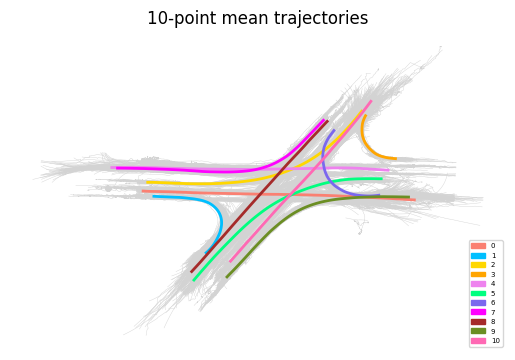

In [26]:
plot_means(gdf,means_100,10)